In [1]:
import xarray as xr
import numpy as np
import tqdm as tq
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from toolbar.filter import MovingAverageFilter
from toolbar.masked import masked   # 气象工具函数
from toolbar.K_Mean import K_Mean, plot_test

# 数据读取
data_year = ['1961', '2022']
# 读取CN05.1逐日最高气温数据
CN051_1 = xr.open_dataset(r"E:\data\CN05.1\1961_2021\CN05.1_Tmax_1961_2021_daily_025x025.nc")
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
CN051 = xr.concat([CN051_1, CN051_2], dim='time')
try:
    Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
except:
    Tmax = xr.concat([CN051_1, CN051_2], dim='time')
    Tmax = masked(Tmax, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域温度
    Tmax = Tmax.sel(time=Tmax['time.month'].isin([6, 7, 8])).groupby('time.year')  # 截取夏季数据
    Tmax_5Day_filt = np.array([[[MovingAverageFilter(iyear[1]['tmax'].data[:, i, j], 'lowpass', [5], np.nan).filted() for j in range(283)] for i in range(163)] for iyear in tq.tqdm(Tmax)])  # 5天滑动平均
    Tmax_5Day_filt = Tmax_5Day_filt.transpose(0, 3, 1, 2) # 转换为(year, day, lat, lon)格式
    Tmax_5Day_filt = xr.DataArray(Tmax_5Day_filt,
                                  coords=[[str(i) for i in range(eval(data_year[0]), eval(data_year[1]) + 1)],
                                          [str(i) for i in range(1, 88 + 1)],
                                          CN051_2['lat'].data,
                                          CN051_2['lon'].data],
                                  dims=['year', 'day', 'lat', 'lon'], )
    Tmax_5Day_filt.to_netcdf(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
    del Tmax

zone_stations = masked((CN051_2-CN051_2+1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
t95 = CN051.quantile(0.95, dim='time')['tmax']
EHD = Tmax_5Day_filt - t95

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [ ]:
EHD = Tmax_5Day_filt - 35

In [33]:
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
EHD20 = EHD.where(EHDstations_zone >= 0.1, np.nan)  # 提取极端高温日占比大于20%
# 获取EHD20的年份和日
EHD20_time = np.zeros((EHD20['year'].size, EHD20['day'].size))
for iyear in range(EHD20['year'].size):
    for iday in range(EHD20['day'].size):
        EHD20_time[iyear, iday] = f"{iyear + 1961}{iday:02d}"
EHD20_time = EHD20_time.reshape(-1)
EHD20 = masked(EHD20, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 减去非研究地区
EHD20 = EHD20.data.reshape(-1, 163*283)
EHD20 = pd.DataFrame(EHD20).dropna(axis=0, how='all')
EHD20_ = EHD20.dropna(axis=1, how='all')

In [37]:
EHD20_time.shape

(5456,)

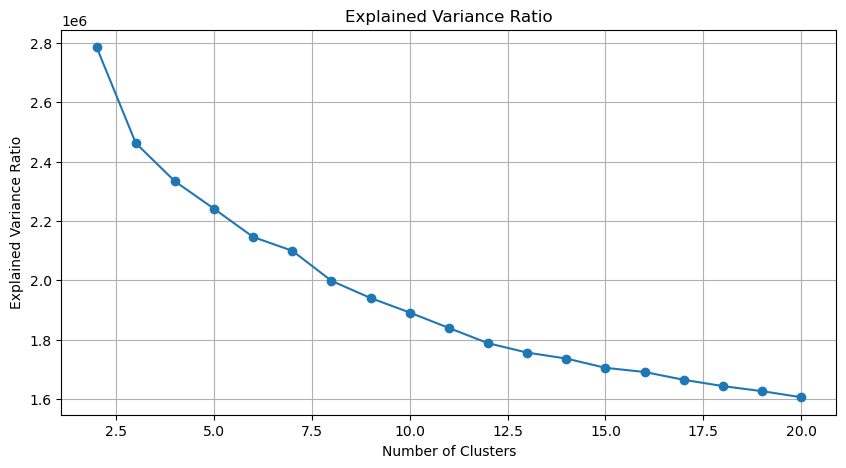

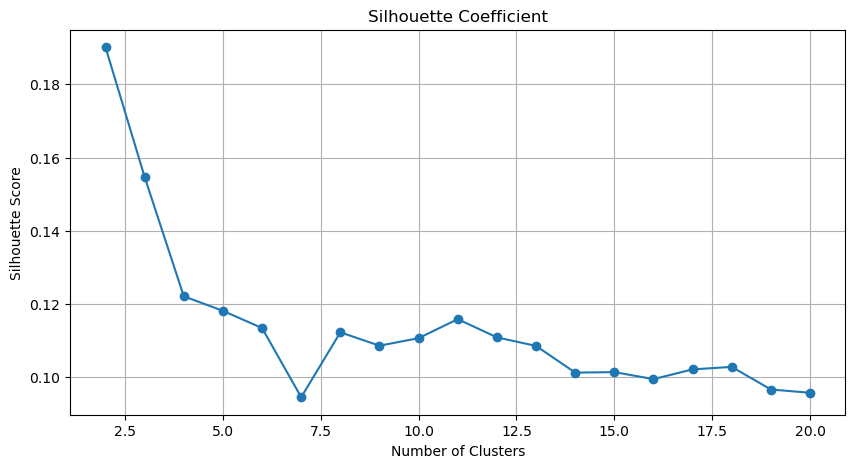

Cluster 0: 图像索引 [   6   17   20   21   22   23   24   25   26   27   48   53   54   68
   69   70   71   72   73   74   75   76   81   82   83   87   91   95
   96   97   98   99  100  101  102  103  104  105  106  107  110  126
  127  132  133  134  135  136  137  138  139  154  155  156  157  158
  179  180  181  182  183  184  185  188  189  190  191  192  193  194
  195  196  197  205  206  207  208  212  213  214  215  216  235  236
  237  254  260  261  262  263  265  266  267  268  269  270  286  287
  288  289  290  306  307  308  309  310  311  312  313  314  315  316
  317  318  319  320  325  326  329  330  331  334  336  366  367  368
  369  370  375  376  377  378  392  393  394  395  396  397  398  413
  417  422  423  424  425  426  427  437  439  440  441  442  443  444
  445  446  453  454  455  464  465  466  480  481  482  483  484  485
  493  494  495  496  505  506  507  508  509  510  511  512  513  514
  533  534  535  536  537  538  542  543  544  545  546  547 

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


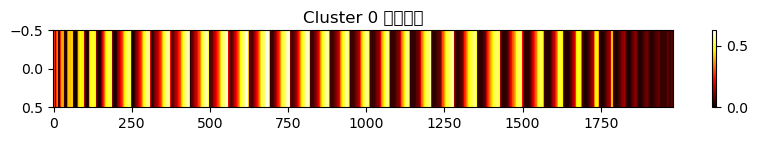

Cluster 1: 图像索引 [   7    8    9   10   11   12   28   29   30   31   32   33   34   49
   50   51   55   56   57   58   59   60   61   62   63   64   65   66
   67  108  111  112  113  114  115  116  117  118  119  120  121  122
  123  124  125  150  151  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  186  187  209
  210  211  220  221  222  223  224  225  231  232  233  234  238  239
  240  241  245  246  264  271  272  291  292  293  294  295  296  297
  298  299  300  301  302  303  304  305  327  328  332  333  340  341
  342  343  344  353  354  355  406  407  408  409  410  411  412  432
  433  434  435  447  448  449  450  451  452  457  458  459  460  461
  462  463  470  486  487  488  489  497  498  504  530  531  532  539
  540  541  589  590  591  592  626  627  628  629  630  631  632  647
  648  649  650  651  652  653  654  700  701  710  711  712  713  723
  724  725  726  727  728  729  730  731  732  733  734  735 

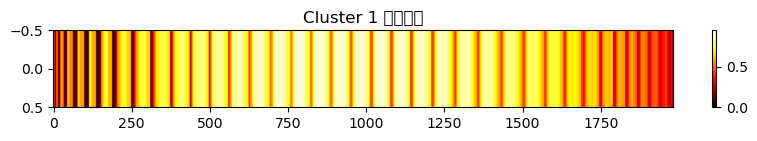

Cluster 2: 图像索引 [   0    1    2    3    4    5   13   14   15   16   18   19   35   36
   37   38   39   40   41   42   43   44   45   46   47   52   77   78
   79   80   84   85   86   88   89   90   92   93   94  109  128  129
  130  131  140  141  142  143  144  145  146  147  148  149  152  153
  198  199  200  201  202  203  204  217  218  219  226  227  228  229
  230  242  243  244  247  248  249  250  251  252  253  255  256  257
  258  259  273  274  275  276  277  278  279  280  281  282  283  284
  285  321  322  323  324  335  337  338  339  345  346  347  348  349
  350  351  352  356  357  358  359  360  361  362  363  364  365  371
  372  373  374  379  380  381  382  383  384  385  386  387  388  389
  390  391  399  400  401  402  403  404  405  414  415  416  418  419
  420  421  428  429  430  431  436  438  456  467  468  469  471  472
  473  474  475  476  477  478  479  490  491  492  499  500  501  502
  503  515  516  517  518  519  520  521  522  523  524  525 

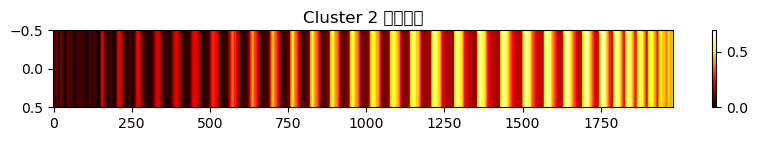

196106.0
196117.0
196120.0
196121.0
196122.0
196123.0
196124.0
196125.0
196126.0
196127.0
196148.0
196153.0
196154.0
196168.0
196169.0
196170.0
196171.0
196172.0
196173.0
196174.0
196175.0
196176.0
196181.0
196182.0
196183.0
196187.0
196203.0
196207.0
196208.0
196209.0
196210.0
196211.0
196212.0
196213.0
196214.0
196215.0
196216.0
196217.0
196218.0
196219.0
196222.0
196238.0
196239.0
196244.0
196245.0
196246.0
196247.0
196248.0
196249.0
196250.0
196251.0
196266.0
196267.0
196268.0
196269.0
196270.0
196303.0
196304.0
196305.0
196306.0
196307.0
196308.0
196309.0
196312.0
196313.0
196314.0
196315.0
196316.0
196317.0
196318.0
196319.0
196320.0
196321.0
196329.0
196330.0
196331.0
196332.0
196336.0
196337.0
196338.0
196339.0
196340.0
196359.0
196360.0
196361.0
196378.0
196384.0
196385.0
196386.0
196387.0
196401.0
196402.0
196403.0
196404.0
196405.0
196406.0
196422.0
196423.0
196424.0
196425.0
196426.0
196442.0
196443.0
196444.0
196445.0
196446.0
196447.0
196448.0
196449.0
196450.0
196451.0
1

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:535: UserWarning: Glyph 2

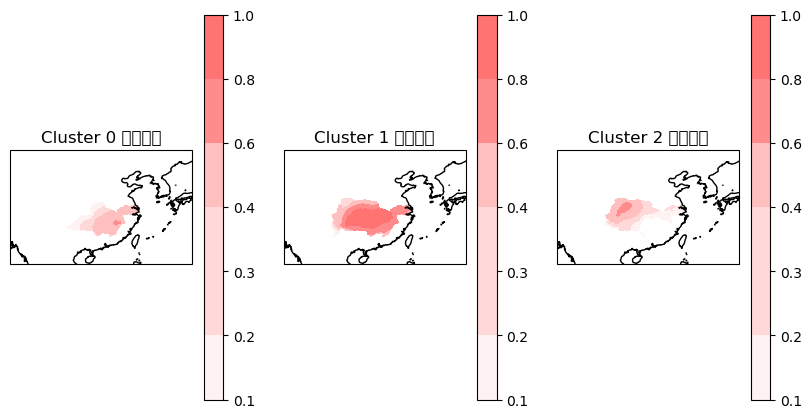

In [40]:
plot_test(EHD20_.to_numpy(), max_clusters=20)
K_s = 3
K = K_Mean(EHD20_.to_numpy(), K_s)
import  cmaps
# 绘制三种聚类的平均分布图
fig = plt.figure(figsize=(10, 5))
for cluster in range(K_s):
    ax = fig.add_subplot(1, K_s, cluster+1, projection=ccrs.PlateCarree())
    ax.set_title(f"Cluster {cluster} 平均分布")
    ax.coastlines()
    ax.set_extent([90, 135, 18, 44])
    KM = []
    for i in K[cluster]['indices']:
        KM.append(EHD20.iloc[i].to_numpy())
        print(EHD20_time[i])
    KM = np.array(KM).mean(axis=0)
    con = ax.contourf(CN051_2['lon'], CN051_2['lat'], KM.reshape(163, 283),
                cmap=cmaps.GMT_polar[10:-4], transform=ccrs.PlateCarree(), levels=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1])
    plt.colorbar(con, ax=ax)
    print('----------------------------------------------------------')
plt.show()